Cross section requires the incident kinetic energy $KE_{inc}$ and the interacting kinetic energy $KE_{int}$.

$KE_{inst}$ is the kinetic energy at the front face of the TPC ($KE_{ff}$) i.e. when the particle first enters LAr.

$$
KE_{ff} = KE_{inst} - \Delta E_{loss}
$$

$\Delta E_{loss}$ is the the energy lost by by the beam particle from the instrumentation to the front face, this needs to be estimating in simulation, then applied to data.

$$
KE_{int} = KE_{ff} - \Delta E_{deposit}
$$

$\Delta E_{deposit}$ can be found in two ways:

 - find $\frac{dE}{dx}$ using the bethe bloch formula from $KE_{ff}$ and then $\int\frac{dE}{dx} dx$
 - use the SCE corrected estimate of the energy deposited at a trejctory point from the calorimetry object, $\sum\Delta E_{calo}$



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from python.analysis import cross_section
from python.analysis import Master, Plots, vector, BeamParticleSelection
import apps.cex_beam_scraper_fits as beam_scraper
import json

import awkward as ak
import copy
import matplotlib.pyplot as plt
import matplotlib
import mplcyberpunk
from particle import Particle
import numpy as np

plt.style.use("cyberpunk")
plt.rcParams["figure.dpi"] = 140

def KE(p, m):
    return (p**2 + m**2)**0.5 - m

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


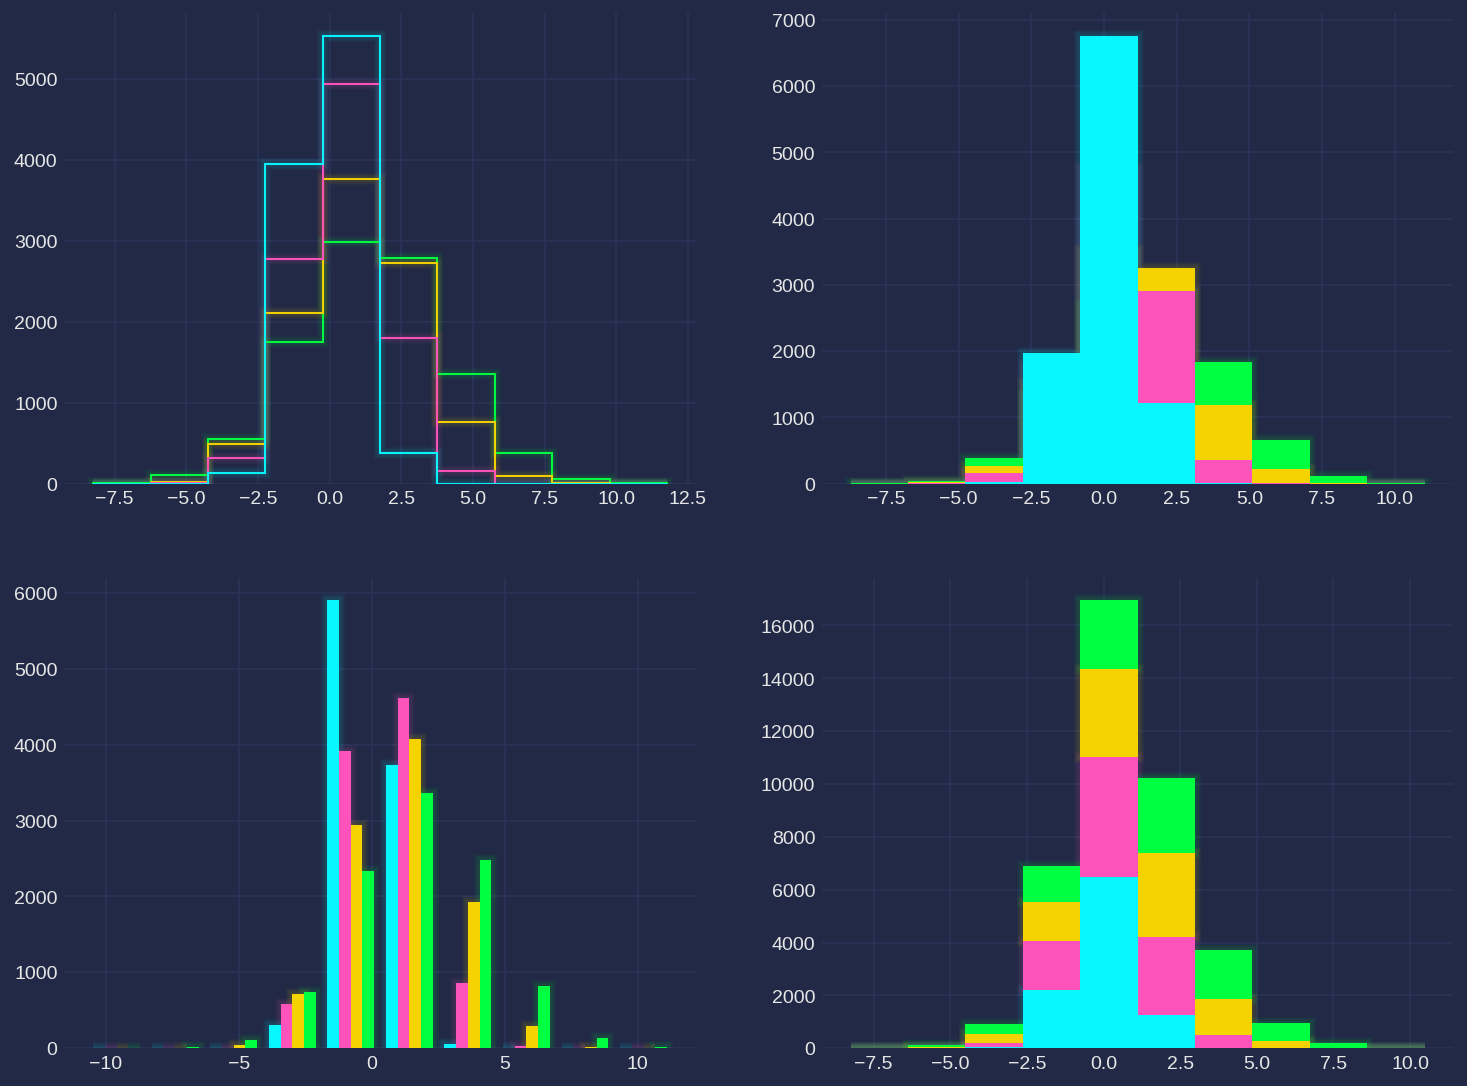

In [2]:
plt.subplots(2, 2, figsize = (6.4 * 2, 4.8 * 2))

mode = ["step", "stepfilled", "bar", "barstacked"]
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(np.random.normal((0, 0.5, 1, 1.5), (1, 1.5, 2, 2.5), (10000, 4)), stacked = False, histtype = mode[i])
    hist_glow(n = 5)


In [3]:
events = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)
fits = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03_fit_values.json"
with open(fits, "r") as file:
    beam_quality_fits = json.load(file)
mask = BeamParticleSelection.CreateDefaultSelection(events, False, beam_quality_fits, verbose = False, return_table = False)

events.Filter([mask], [mask])

# selection = cross_section.LoadSelectionFile("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01_selection_masks.dill")
# events.Filter([selection["beam_selection"]], [selection["beam_selection"]])

number of entries before|after PiBeamSelection: 141548|102443
number of entries before|after PandoraTagCut: 141548|123438
number of entries before|after CaloSizeCut: 141548|125589


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 141548|115682
number of entries before|after BeamQualityCut: 141548|83800
number of entries before|after APA3Cut: 141548|121291
number of entries before|after MedianDEdXCut: 141548|131247


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


In [4]:
true_ff_ind = ak.num(events.trueParticles.beam_traj_pos.z) - ak.argmax((events.trueParticles.beam_traj_pos.z < 0)[:, ::-1], -1) - 1
pitches = vector.magnitude(vector.vector(**{i : ak.Array(map(beam_scraper.dist_into_tpc, events.trueParticles.beam_traj_pos[i], true_ff_ind)) for i in ["x", "y", "z"]}))
first_KE = ak.Array(map(beam_scraper.ff_value, events.trueParticles.beam_traj_KE, true_ff_ind))
true_ffKE = beam_scraper.GetTrueFFKE(first_KE, pitches) # get the true Kinetic energy as the front face of the TPC


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in multiply
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in add
  result = getattr(ufunc, method)(


In [5]:
KE_inst = KE(events.recoParticles.beam_inst_P, Particle.from_pdgid(211).mass)

Text(64.79166666666667, 0.5, '$\\mu(KE^{reco}_{inst} - KE^{true}_{ff})$')

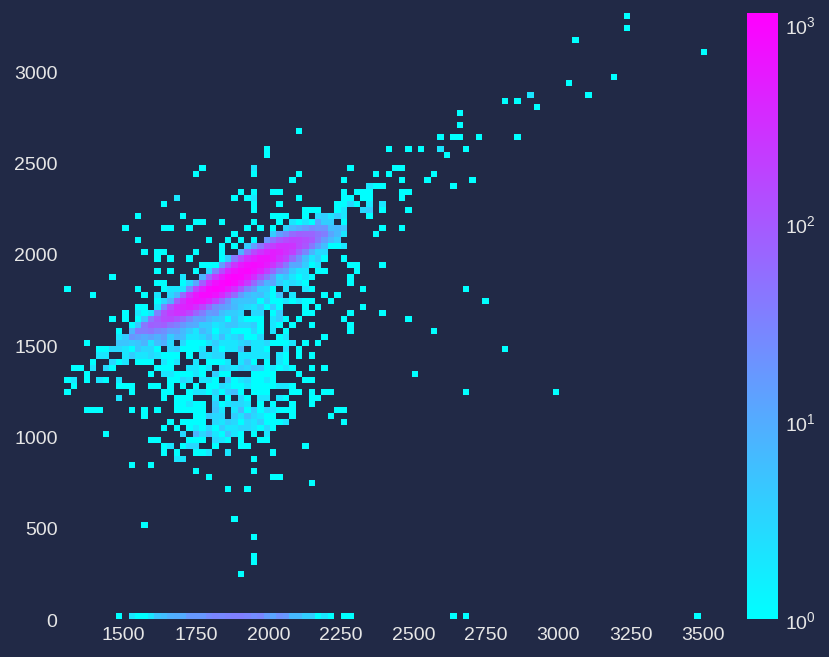

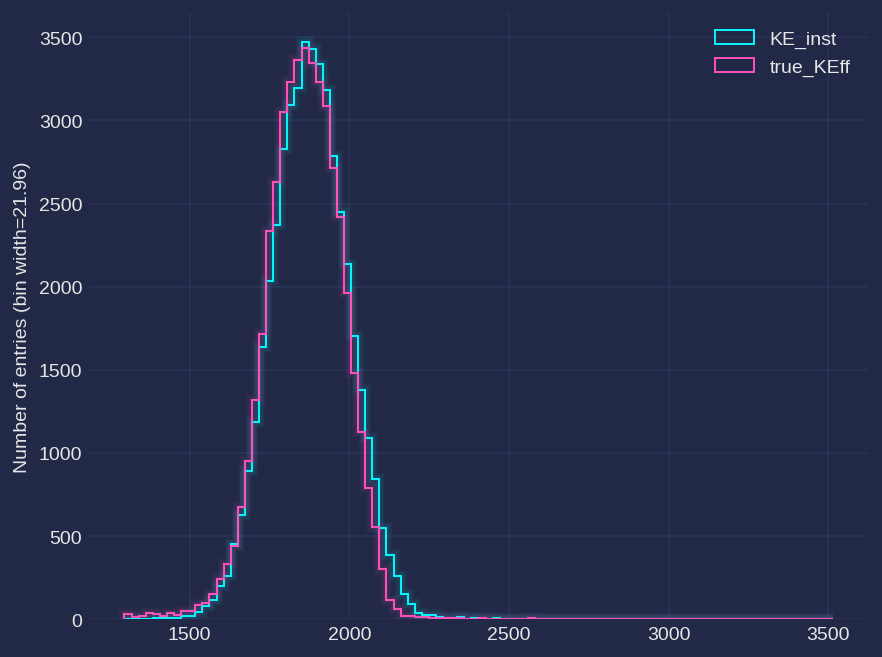

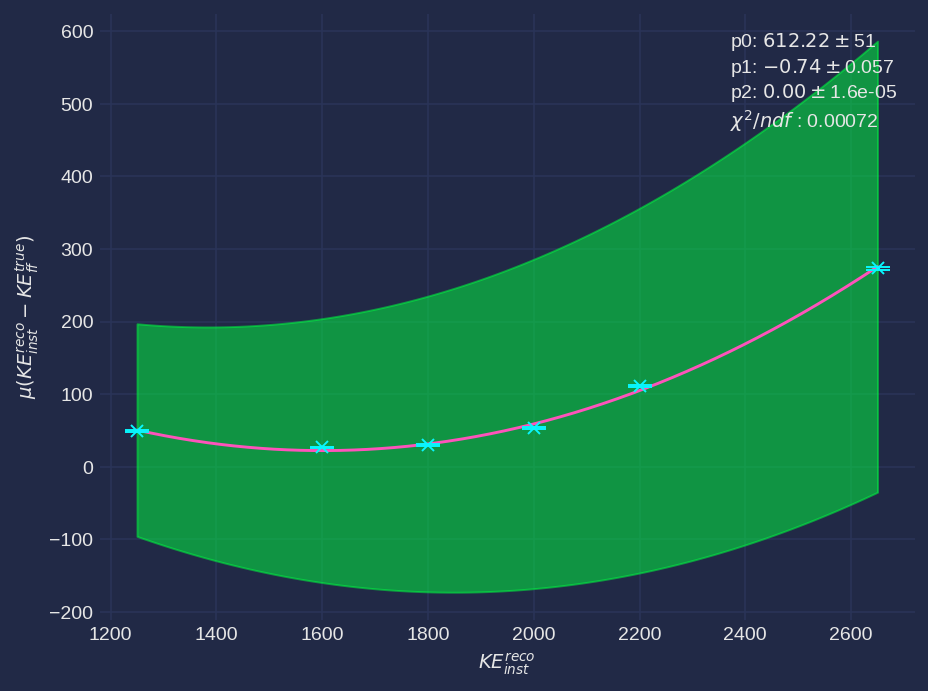

In [8]:
Plots.PlotHist2D(KE_inst, true_ffKE, cmap = "cool")
Plots.PlotHistComparison([KE_inst, true_ffKE], labels = ["KE_inst", "true_KEff"], density = False)
hist_glow()

bins = ak.Array([1000, 1500, 1700, 1900, 2100, 2300, 3000])

binned_data = {"KE_inst": [], "KEff_true" : [], "KE_first_true" : []}
for i in range(len(bins)-1):
    mask = (KE_inst > bins[i]) & (KE_inst < bins[i + 1])
    binned_data["KE_inst"].append( KE_inst[mask] )
    binned_data["KEff_true"].append( true_ffKE[mask] )
    binned_data["KE_first_true"].append( first_KE[mask] )
binned_data = {i : ak.Array(binned_data[i]) for i in binned_data}


ak.mean(binned_data["KE_inst"] - binned_data["KEff_true"], axis = -1)

x = (bins[1:] + bins[:-1]) / 2
xerr = abs(x - bins[1:])

def poly2d(x, A, B, C):
    return C * (x**2) + (B * x) + A

plt.figure()
cross_section.Fitting.Fit(x, ak.mean(binned_data["KE_inst"] - binned_data["KEff_true"], axis = -1), ak.std(binned_data["KE_inst"] - binned_data["KEff_true"], axis = -1) / np.sqrt(ak.count(binned_data["KEff_true"])), poly2d)
plt.xlabel("$KE^{reco}_{inst}$")
plt.ylabel("$\mu(KE^{reco}_{inst} - KE^{true}_{ff})$")
# plt.figure()
# plt.errorbar(x, ak.mean(binned_data["KE_inst"] - binned_data["KEff_true"], axis = -1), yerr = ak.std(binned_data["KE_inst"] - binned_data["KEff_true"], axis = -1) / ak.count(binned_data["KEff_true"]), marker = "x", linestyle = "", capsize = 3, xerr = xerr)

